<a href="https://colab.research.google.com/github/Mic-73/GenAI/blob/main/HW4/EC_Larger_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Author: Michael Wood

Purpose: Build and train a Generative Adversarial Network (GAN) using the LSUN (Large-scale Scene Understanding) dataset, specifically focusing on the bedroom category. The goal is to train the GAN to generate realistic bedroom images based on the patterns learned from the training data.
* LSUN was created to advance research in image understanding and computer vision, particularly in the context of scene recognition and image generation (https://www.tensorflow.org/datasets/catalog/lsunLinks to an external site.)

* It provides a large set of images categorized into various scene types, making it suitable for training and evaluating models in tasks like image generation, classification, and segmentation.

* The dataset includes several scene categories, such as Bedrooms, Bridges, Churches, etc.

* Each category contains thousands of images, allowing for robust training of models.

* The dataset is available for download from the LSUN website: https://www.kaggle.com/datasets/jhoward/lsun_bedroom.

* Researchers and developers typically choose specific categories and download them accordingly.

Note: Initial code for importing and loading the data, setting up training the model, and sampling a number of training and generated images and comparing the two sets was taken from the assignment page on Canvas. Initial code for setting up the discriminator, generator, ImageGenerator class, and DCGAN class was taken from the course's Github repo here: https://github.com/bforoura/GenAI/blob/main/Module4/dcgan.ipynb. The code was modified to fit the assignment's requirements.

---

# Code

## 1. Download the LSUN bedrooms dataset and preprocess the images for training.

In [ ]:
#@title Importing Libraries

# numerical operations
import numpy as np

# used for plotting
import matplotlib.pyplot as plt

# used for tensors
import tensorflow as tf

import keras
from keras import layers
#from keras import ops

from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
    utils
)
#from notebooks.utils import

# Extra libraries for callbacks and graph visualization
import tensorflow.keras.backend as K


from tensorflow.keras.utils import plot_model
from PIL import Image
import io

from scipy.stats import norm

from scipy.io import loadmat

import os
import random
import shutil

In [ ]:
#@title PARAMETERS

IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 256
Z_DIM = 100
num_examples_to_generate = 16

EPOCHS = 50

LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

In [ ]:
#@title Important the Data

from google.colab import drive
import zipfile
import os
import random
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
zip_file_path = '/content/drive/My Drive/Colab Notebooks/GenAI/lsun_bedroom.zip'
extract_to = '/content/'

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

Mounted at /content/drive


In [ ]:
#@title Creating the Subset

# Define paths
dataset_dir = '/content/sample/data0/lsun/bedroom'
subset_dir = '/content/lsun_bedroom_subset/'
num_images = 150000                                   # 150,000 IMAGES!

# Create the subset directory if it doesn't exist
os.makedirs(subset_dir, exist_ok=True)

# Gather all image files in the dataset directory
image_files = []
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith(('.jpg')):
            image_files.append(os.path.join(root, file))

# Randomly select a subset of images
selected_images = random.sample(image_files, min(num_images, len(image_files)))

# Copy selected images to the new directory
for image in selected_images:
    shutil.copy(image, os.path.join(subset_dir, os.path.basename(image)))

print(f"Subset created with {len(selected_images)} images in {subset_dir}.")

Subset created with 150000 images in /content/lsun_bedroom_subset/.


In [ ]:
#@title Creating the Training Set

train_data =  tf.keras.preprocessing.image_dataset_from_directory(
    "/content/lsun_bedroom_subset/",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 150000 files.


In [ ]:
#@title Preprocessing the Data

def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))

In [ ]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

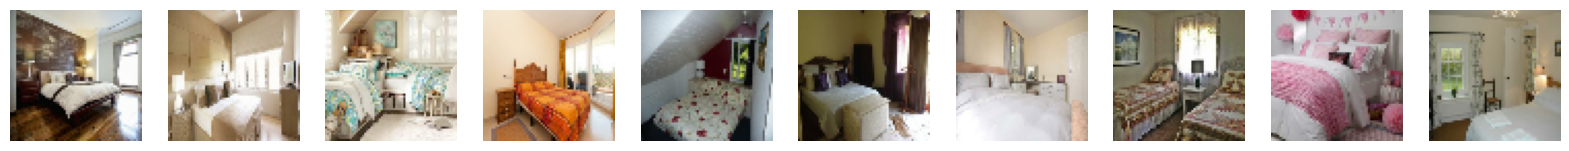

In [ ]:
#@title Display a Sample of the Training set

# from utils import display, sample_batch
train_sample = sample_batch(train)
display(train_sample)

## 2. Create the generator and discriminator models for the GAN architecture

In [ ]:
#@title Create the Generator

def make_generator_model():
    model = tf.keras.Sequential()                                                                                                  # Sequential
    model.add(layers.Input(shape=(Z_DIM,)))                                                                                        # Input Layer
    model.add(layers.Reshape((1, 1, Z_DIM)))                                                                                       # Reshape
    model.add(layers.Conv2DTranspose(512, kernel_size=4, strides=1, padding="valid", use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2DTranspose(CHANNELS, kernel_size=4, strides=2, padding="same", use_bias=False, activation="tanh", ))

    return model

In [ ]:
#@title Create the Discriminator

def make_discriminator_model():
    model = tf.keras.Sequential()                                # Sequential
    model.add(layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)))                 # Input Layer
    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(rate=0.3))                                              # Dropout Layer
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(rate=0.3))                                              # Dropout Layer
    model.add(layers.Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(rate=0.3))                                              # Dropout Layer
    model.add(layers.Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(rate=0.3))                                              # Dropout Layer
    model.add(layers.Conv2D(1, kernel_size=4, strides=1, padding="same", use_bias=False, activation="sigmoid", ))
    model.add(layers.Flatten())                                                      # Flatten

    return model

In [ ]:
#@title Create the DCGAN Class

class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [ ]:
#@title Create a DCGAN

# Create models
generator = make_generator_model()
discriminator = make_discriminator_model()

dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

## 3. Train the GAN on the bedrooms dataset, iteratively improving the generator's ability to produce realistic images and the discriminator's ability to distinguish between real and generated images.

In [ ]:
#@title Compile the Model

dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [ ]:
#@title ImageGenerator Class

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()


In [ ]:
#@title Train the Model

history = dcgan.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

Epoch 1/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 203s 299ms/step - d_acc: 0.8279 - d_fake_acc: 0.8448 - d_loss: 0.3231 - d_real_acc: 0.8110 - g_acc: 0.1552 - g_loss: 1.8364
Epoch 2/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 152s 252ms/step - d_acc: 0.8820 - d_fake_acc: 0.8900 - d_loss: 0.1639 - d_real_acc: 0.8741 - g_acc: 0.1100 - g_loss: 2.7354
Epoch 3/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 144s 246ms/step - d_acc: 0.9180 - d_fake_acc: 0.9224 - d_loss: 0.0292 - d_real_acc: 0.9136 - g_acc: 0.0776 - g_loss: 3.9617
Epoch 4/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 145s 247ms/step - d_acc: 0.9287 - d_fake_acc: 0.9316 - d_loss: -0.0422 - d_real_acc: 0.9258 - g_acc: 0.0684 - g_loss: 4.8683
Epoch 5/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 202s 247ms/step - d_acc: 0.9214 - d_fake_acc: 0.9240 - d_loss: -0.0167 - d_real_acc: 0.9188 - g_acc: 0.0760 - g_loss: 5.5543
Epoch 6/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 201s 247ms/step - d_acc: 0.9496 - d_fake_acc: 0.9522 - d_loss: -0.1988 - d_real_acc: 0.9471 - g_acc: 0.0478 - g_loss: 6.9464
Epoch 7/50
58

## 4. Create new Images with Generator

In [ ]:
#@title Sample Points in the Latent Space

# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [ ]:
#@title Decode the sampled points
reconstructions = generator.predict(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


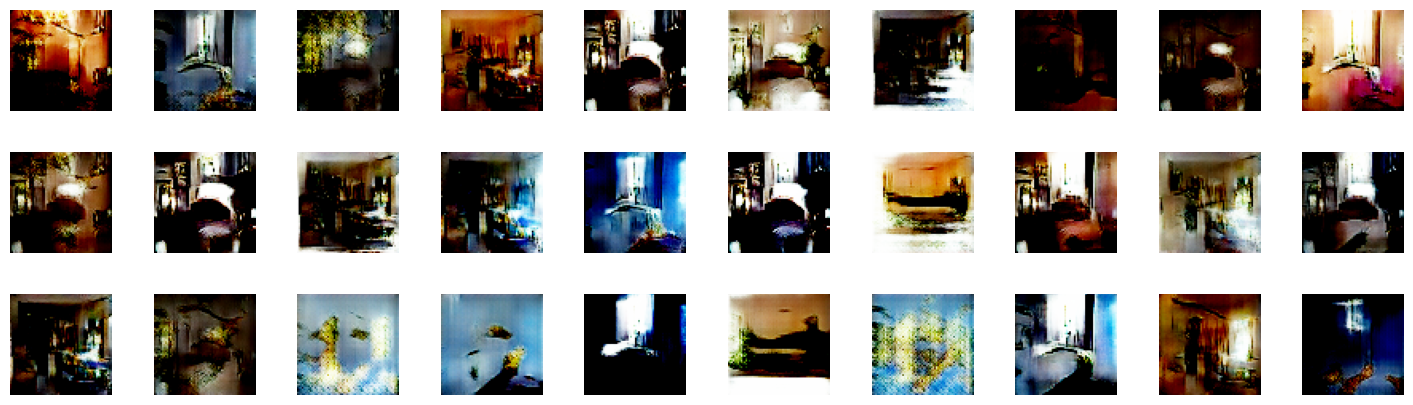

In [ ]:
#@title Display the Decoded Images

# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

---
# Discussion Points


* The trade-off between generating high-quality images and maintaining diversity in the output is a challenge for GANs. While high-quality images are the desired result, they may appear too similar to the images in the training data. This means that the model has overfitted on the training set, and it is not given many oppurtunities to learn and generate *new* images. Maintaining diversity in the ouput is important to avoid this outcome. As for this particular model, it seems that the generated images are different enough from the training images and cover a variety of different colors and styles. However, some areas in certain images may seem similar in shape or color as well.
* Experimenting with more than 50 epochs may yield better results from the model. Although, that may come with a greater risk of overfitting as well. This model is currently only using a subset of 150,000 images, but if it were to include the entire set of ~300,000 images, then that might yield better generated results. As for the batch size, a smaller batch size of 32 or 64 may increase the accuracy of the model, but that will also increase the amount of time it will take to train the model. The model architecture could also always be adjusted and fine-tuned to try and find the best fit for this particular dataset.
* Practical applications for this type of generative model could include architectural problems, home and clothing designs, video game design, and animated movie design. While this module does not perform this task, a GAN model could also be used for text-to-image translation (prompting).
* Extra Credit: Measurements like the Inception Score (IS) and the Inception Distance (ID) can provide quantitative evaluations of image quality and diversity. The IS can measure how concise and diverse the generated images are depending on how well the images can be classified. The ID can also measure the accuracy and diversity of the generated images by comparing them to actual  images related to the dataset. Both of these measurements can quantitatively measure the GANs performance and the accuracy of its generated images.

---